# zachmoshe.com - Random Polygons

This python notebook refers to the [random polygons post in my blog](http://www.zachmoshe.com/random-polygons). It contains some code I've used to simulate cyclic and regular rows and grids in order to check if the estimated expression I got there was valid.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random


# Classes and some utilities

The following defines the `BaseGrid` class which supports initialization of a grid (cyclic or not) and removal of separators (called here boundaries). It can also apply a specific separator percentage on all separators. A `BaseGrid` (and all its descendants) can be queried for the distribution of block sizes (i.e. how many blocks are of every size in the row).

In [51]:
class BaseGrid:
    def __init__(self, rows, cols, cyclic=False):
        b = np.zeros((rows, cols), dtype='int')
        for i in range(b.shape[0]):
            for j in range(b.shape[1]):
                b[i][j] = i*b.shape[1]+j
        self.matrix = b
        self.rows = rows
        self.cols = cols
        self.cyclic = cyclic

    
    def iterate_boundaries(self):
        for i in range(self.rows if self.cyclic else self.rows-1):
            for j in range(self.cols):
                yield('h', i, j)
                
        for i in range(self.rows):
            for j in range(self.cols if self.cyclic else self.cols-1):
                yield('v', i, j)
        
        
    ALLOWED_TYPES = ['v', 'vertical', 'h', 'horizonal']
    def remove_boundary(self, boundary):
        type, row, col = boundary
        assert type in self.ALLOWED_TYPES, "type must be one of {}".format(ALLOWED_TYPES)
        
        if type == 'vertical' or type == 'v':
            row_range = range(self.rows)
            col_range = range(self.cols if self.cyclic else self.cols-1)
            
            assert row in row_range, "row must be between 0 and {}".format(len(row_range)-1)
            assert col in col_range, "vertical col must be between 0 and {}".format(len(col_range)-1)
            c1 = self.matrix[row][col]
            c2 = self.matrix[row][(col+1) % self.matrix.shape[1]]
            self.matrix[self.matrix == c2] = c1

        if type == 'horizontal' or type == 'h':
            row_range = range(self.rows if self.cyclic else self.rows-1)
            col_range = range(self.cols)
            
            assert row in row_range, "row must be between 0 and {}".format(len(row_range)-1)
            assert col in col_range, "vertical col must be between 0 and {}".format(len(col_range)-1)
            c1 = self.matrix[row][col]
            c2 = self.matrix[(row+1) % self.matrix.shape[0]][col]
            self.matrix[self.matrix == c2] = c1
    
    
    def blocks_dist(self):
        return np.bincount(np.bincount(self.matrix.flatten()))[1:]

    def __repr__(self):
        return str(self.matrix)

    def __len__(self):
        return self.matrix.size
        
    def apply_boundary_pct(self, p):
        for b in self.iterate_boundaries():
            if random.random() > p:
                self.remove_boundary(b)
    
    def join_cells(self, r1, c1, r2, c2):
        v1 = self.matrix[r1][c1]
        v2 = self.matrix[r2][c2]
        self.matrix[self.matrix==v2] = v1
        
        
    
class Row(BaseGrid):
    def __init__(self, N=10, cyclic=False):
        super(Row, self).__init__(1, N, cyclic=cyclic)
        
    @staticmethod
    def num_cells(n):
        return n

        
class Grid(BaseGrid):
    @staticmethod
    def num_cells(n):
        return n**2
    

        

    
class StraightRow(Row):    
    pass
    
class CyclicRow(Row):
    def __init__(self, N=10):
        super(CyclicRow, self).__init__(N, cyclic=True)
        
        
        
class StraightGrid(Grid):
    def __init__(self, rows, cols=None):
        if not cols:
            cols = rows
        super(StraightGrid, self).__init__(rows, cols)

class CyclicGrid(Grid):        
    def __init__(self, rows, cols=None):
        if not cols:
            cols = rows
        super(CyclicGrid, self).__init__(rows, cols, cyclic=True)


## Some utilities

In [59]:
@np.vectorize
def get_avg_blocks_dist(N,p,cls,num_iters=1000):
    block_size_dist = []

    cls_num_cells = cls.num_cells(N)
    
    for i in range(num_iters):
        r = cls(N)
        r.apply_boundary_pct(p)

        blocks_dist = r.blocks_dist()
        block_size_dist.append(
            np.concatenate([blocks_dist, np.zeros(cls_num_cells)])[:cls_num_cells]
        )
    
    bsd = np.array(block_size_dist)
    avg_blocks_dist = bsd.mean(axis=0)
    avg_num_blocks = bsd.sum(axis=1).mean()
    
    return avg_blocks_dist, avg_num_blocks
    

In [60]:
@np.vectorize
def estimate_cyclic_enk(n,k,p):
    if k<n:
        return n*p**2*(1-p)**(k-1)
    else:
        return n*p*(1-p)**(n-1) + (1-p)**n


In [61]:
@np.vectorize
def estimate_cyclic_num_blocks(n,p):
    return n*p + (1-p)**n


# Verify the E(k) expression for a cyclic row

Using the CyclicRow class from before, we'll generate 1000 rows for every p (with N=8) and create 8 charts of the estimated E(i) vs. the actual one (an average of the 1000 iterations). You can play with N later to test different row sizes. You can also replace `cls` with StraightRow to see how that behaves (but then I also recommend to raise N to at least 25)

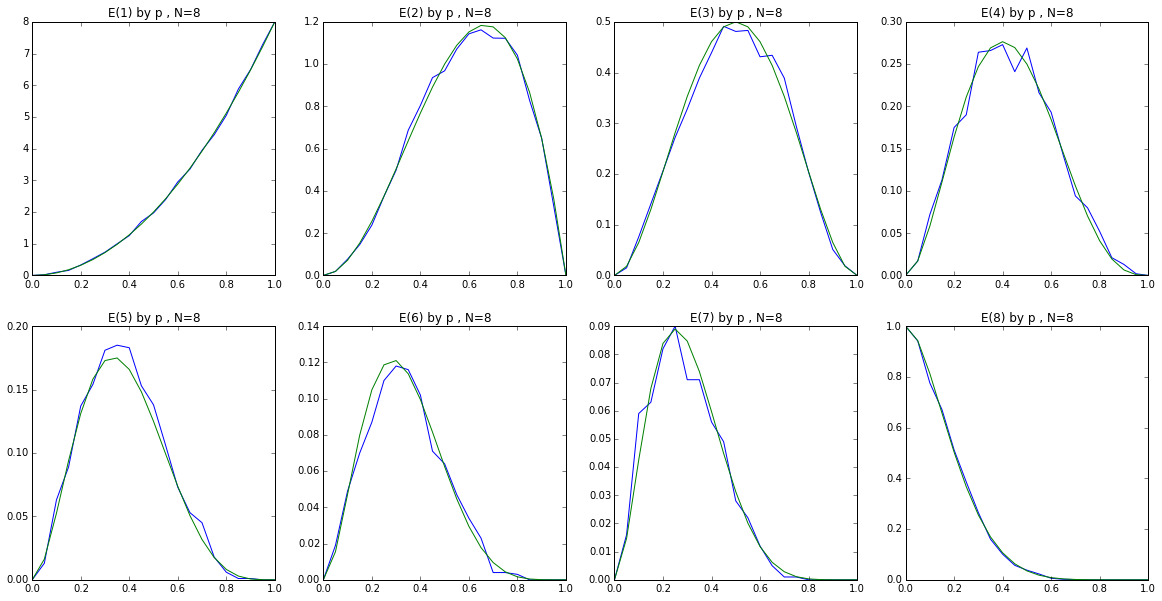

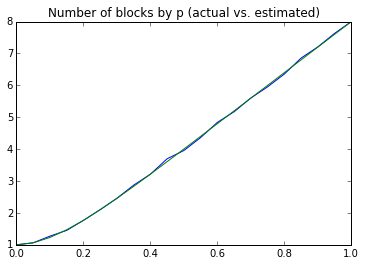

In [62]:
N = 8
ps = np.linspace(0,1,21)
cls = CyclicRow
# cls = StraightRow   # try this too (with N=25 or higher)

blocks_dist_by_p = []
num_blocks_by_p = []
for p in ps:
    avg_blocks_dist, avg_num_blocks = get_avg_blocks_dist(N,p,cls, num_iters=1000)
    blocks_dist_by_p.append(avg_blocks_dist)
    num_blocks_by_p.append(avg_num_blocks)

blocks_dist_by_p = np.array(blocks_dist_by_p)
    
    
chart_grid_cols = 4
chart_grid_rows = int(np.ceil(N/chart_grid_cols))
plt.figure(figsize=(5*chart_grid_cols,5*chart_grid_rows))

for k in range(1,N+1):
    actual = blocks_dist_by_p[:,k-1]
    estimate = [estimate_cyclic_enk(N,k,p) for p in ps]

    plt.subplot(chart_grid_rows, chart_grid_cols, k)
    plt.plot(ps, actual)
    plt.plot(ps, estimate)
    plt.title("E({}) by p , N={}".format(k, N))

plt.show()

plt.plot(ps, num_blocks_by_p)
plt.plot(ps, estimate_cyclic_num_blocks(N,ps))
plt.title("Number of blocks by p (actual vs. estimated)")
plt.show()


# Verify the cyclic assumption for a row

We'll iterate several values of N and for each of them we'll calculate the average diff (in ABS %) between the number of blocks for a CyclicRow and a StraightRow.

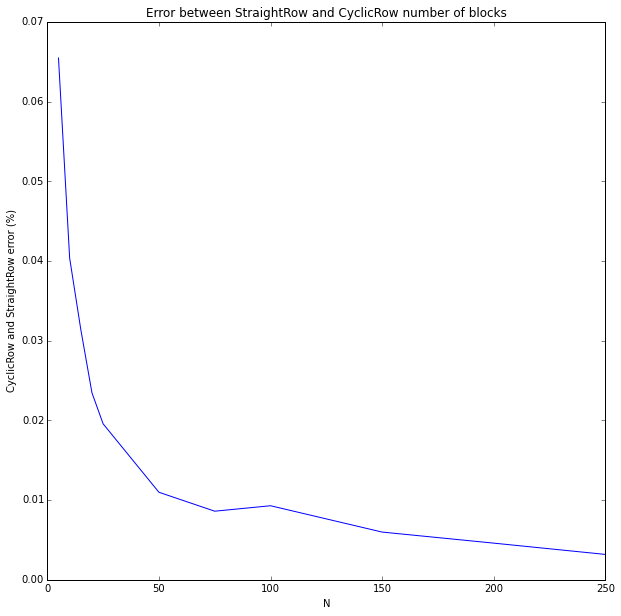

In [63]:
ns = [5,10,15,20,25,50,75,100,150,200,250]
ps = np.linspace(0,1,11)


@np.vectorize
def avg_err(n,cls1,cls2,num_iters=50):
    tmp = []
    for p in ps:
        _, cls1_avg_num_blocks = get_avg_blocks_dist(n,p,cls1, num_iters=num_iters)
        _, cls2_avg_num_blocks = get_avg_blocks_dist(n,p,cls2, num_iters=num_iters)
        
        tmp.append(abs(cls1_avg_num_blocks - cls2_avg_num_blocks))
    return np.mean(tmp)
    

se = avg_err(ns,CyclicRow, StraightRow) / ns
plt.figure(figsize=(10,10))
plt.title("Error between StraightRow and CyclicRow number of blocks")
plt.xlabel("N")
plt.ylabel("CyclicRow and StraightRow error (%)")
plt.plot(ns, se)

# Verify the cyclic assumption for a grid

The same as before, this time for a grid.

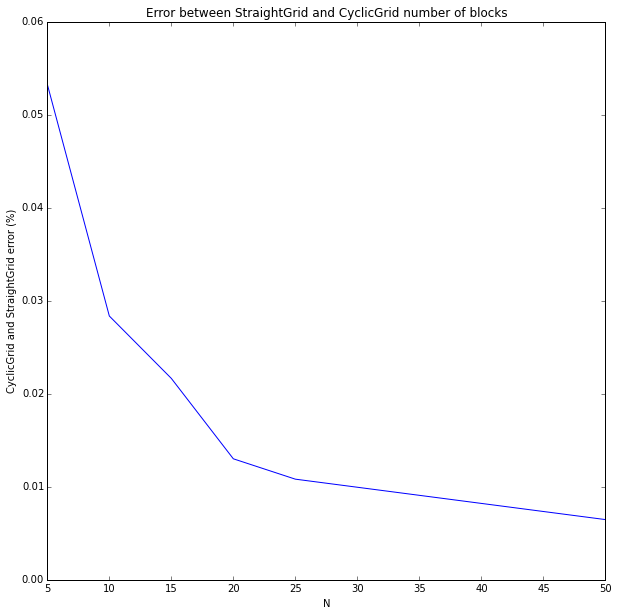

In [25]:
ns = [5,10,15,20,25,50]
ps = np.linspace(0,1,11)

se = avg_err(ns,CyclicGrid, StraightGrid,num_iters=20) / np.power(ns,2)
plt.figure(figsize=(10,10))
plt.title("Error between StraightGrid and CyclicGrid number of blocks")
plt.xlabel("N")
plt.ylabel("CyclicGrid and StraightGrid error (%)")
plt.plot(ns, se)

# Performance of the Grid Expression

We'll run 100 iterations of StraightGrid for all p's and measure the actual average number of blocks vs. the estimated one that we get from the expression we've got.

In [64]:
@np.vectorize
def estimate_cyclic_grid_block_size(n,p):
    if p==0: 
        return n**2
    return (( (1-p)**n*(n*p-p+2)+p-2 ) / p )**2

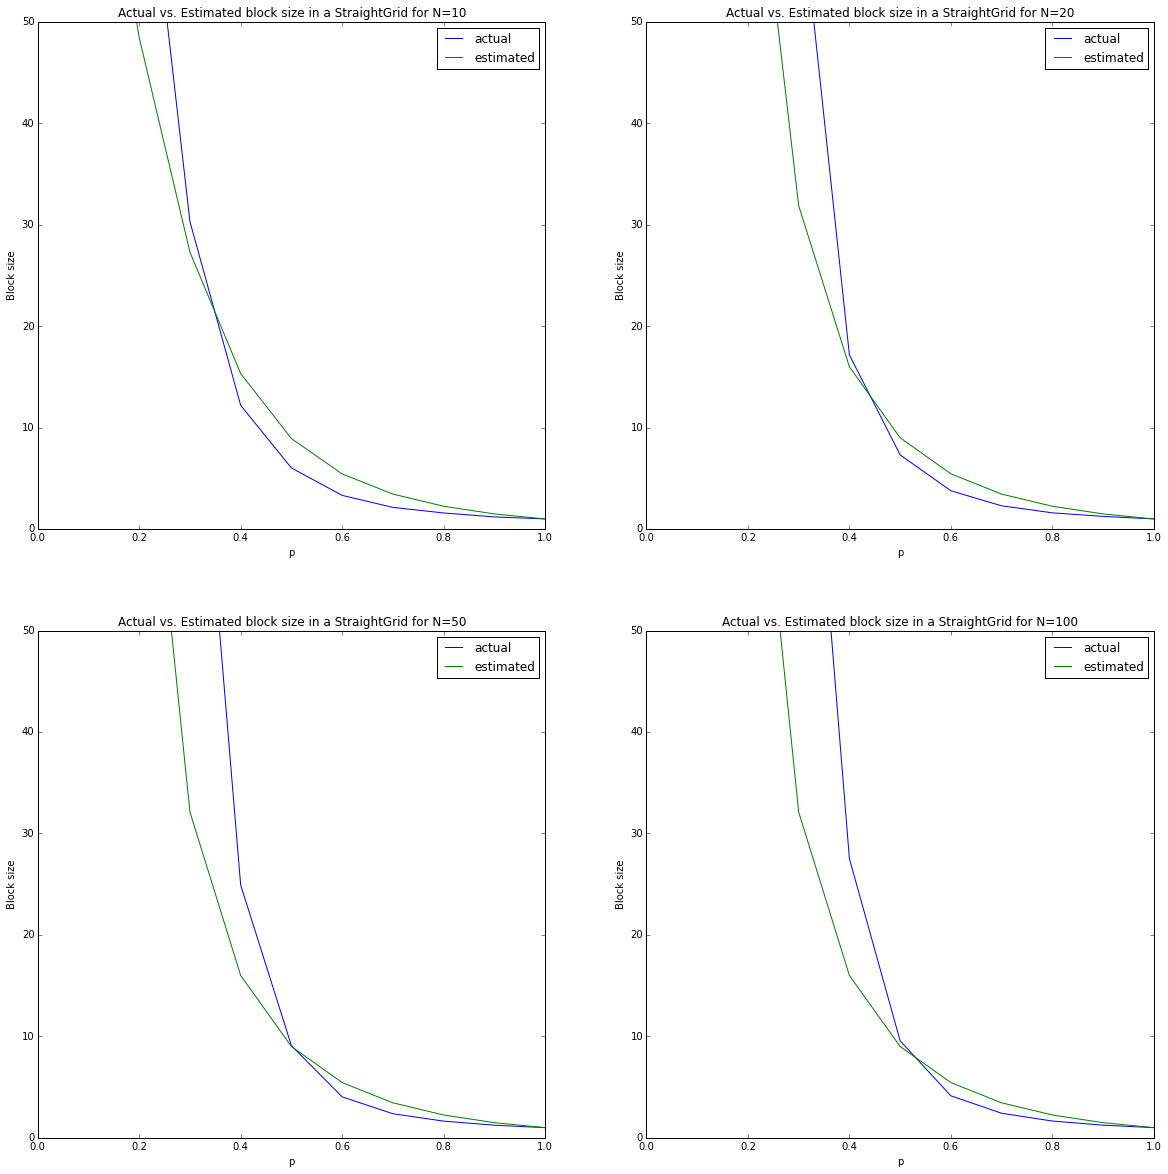

In [72]:
ns = [10,20,50,100]
ps = np.linspace(0,1,11)

plt.figure(figsize=(20,10*len(ns)/2))

cnt = 0
for N in ns:
    cnt += 1
    
    actual_block_size = [ N**2 / get_avg_blocks_dist(N,p,StraightGrid, num_iters=20)[1] for p in ps ]
    est_block_size = [ estimate_cyclic_grid_block_size(N,p) for p in ps ]

    plt.subplot(len(ns)/2, 2, cnt)

    plt.plot(ps, actual_block_size, label='actual')
    plt.plot(ps, est_block_size, label='estimated')
    plt.legend()
    plt.xlabel('p')
    plt.ylabel('Block size')
    plt.title("Actual vs. Estimated block size in a StraightGrid for N={}".format(N))

    axes = plt.gca()
    axes.set_ylim([0,50])


# That's it!!